In [35]:
# My functions
from PhaseEstimation import hamiltonians as H, vqe 
from PhaseEstimation import annni_model as ANNNI
from PhaseEstimation import general as qmlgen

# Plotting
import matplotlib.pyplot as plt
from matplotlib import colors
import plotly.graph_objects as go

# Others
import numpy as np 
import jax
import copy

# QML
import pennylane as qml
import jax.numpy as jnp


In [48]:
# FORWARD SHIFT : T|100> = |010>
def T(n_qubits : int):
    qubit = 0
    for qubit_next in np.arange(1,n_qubits):
        qml.SWAP(wires = [qubit, qubit_next])

# BACKWARD SHIFT TD|010> = |100>
def T_dag(n_qubits : int):
    for qubit, qubit_next in zip(np.arange(0, n_qubits), np.arange(1, n_qubits)):
        qml.SWAP(wires = [qubit, qubit_next])

def compute_transsymm_distance(psi):
    n_qubits = int(np.log2(len(psi)))
    rho      = jnp.outer(psi, jnp.conj(psi))

    Tmat     = qml.matrix(T)(n_qubits)
    Tmat_dag = qml.matrix(T_dag)(n_qubits)

    rhoT = Tmat @ rho @ Tmat_dag

    A = rho - rhoT 

    return .5 * jnp.trace(jnp.sqrt(jnp.conj(A).T @ A))
    
jv_compute_transsym_distance = jax.jit(jax.vmap( compute_transsymm_distance, (0) ))

def trace_distance(H):
    n_qubits = int(np.log2(len(psi)))
    rho      = jnp.outer(psi, jnp.conj(psi))

    Tmat     = qml.matrix(T)(n_qubits)
    Tmat_dag = qml.matrix(T_dag)(n_qubits)

    rhoT = Tmat @ rho @ Tmat_dag

    A = rho - rhoT 

    return .5 * jnp.trace(jnp.sqrt(jnp.conj(A).T @ A))
    
jv_compute_transsym_distance = jax.jit(jax.vmap( compute_transsymm_distance, (0) ))

In [3]:
N         = 8   # Number of qubits
n_kappas  = 100 # Discretization (x-axis)
n_hs      = 100 # Discretization (y-axis)
kappa_max = 1   # Mamimum x value
h_max     = 2   # Maximum y value

100%|██████████| 10000/10000 [01:13<00:00, 136.50it/s]


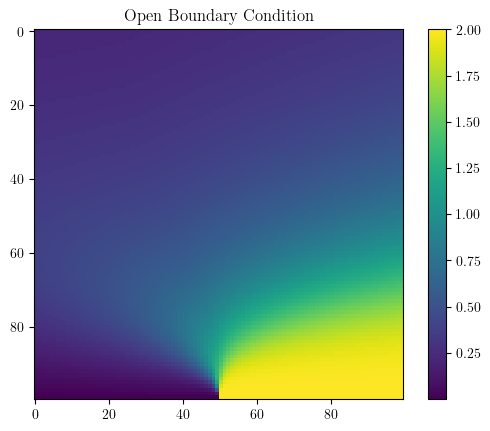

100%|██████████| 10000/10000 [01:17<00:00, 128.31it/s]


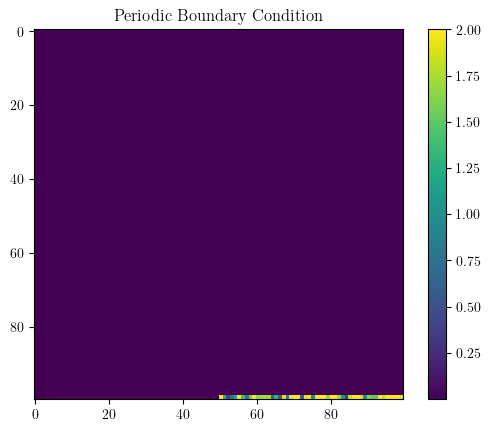

In [9]:
for ring in [False, True]:
    Hs = H.hamiltonian(ANNNI.build_Hs, N = N, n_hs = n_hs, n_kappas = n_kappas, kappa_max=kappa_max, ring = ring)
    E0, PSI0 = H.get_e_psi(Hs, 0)
    distances = jv_compute_transsym_distance(jnp.array(PSI0))
    distances = np.reshape(distances, (n_hs,n_kappas))

    plt.title('Periodic Boundary Condition') if ring == True else plt.title('Open Boundary Condition')
    plt.imshow(np.rot90(distances)); plt.colorbar()
    plt.show()